# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import keras
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

2024-06-27 01:42:10.259117: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 01:42:10.282414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 01:42:10.282438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 01:42:10.283120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 01:42:10.287298: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.1
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-27 01:42:11.282645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 01:42:11.306761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 01:42:11.307032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Model Selection

Simple neural netwok with dense layers is chosen, as we have non-time-series tabular data.


## Feature Engineering

Feature engineering in terms of calculating / selecting new features was already handled in the [EDA notebook](../1_DatasetCharacteristics/exploratory_data_analysis.ipynb).

In [5]:
# Load the dataset
data_path1 = '../Data/'
data_path2 = '../data/'

# Check which path exists
if os.path.exists(data_path1):
    data_path = data_path1
elif os.path.exists(data_path2):
    data_path = data_path2
else:
    raise FileNotFoundError("Neither data_path1 nor data_path2 exists")

full_path = os.path.join(data_path, 'preprocessed_df_v2.csv')

In [6]:
df = pd.read_csv(full_path)

# Drop not needed features
columns_to_drop = ['mental', 'physical', 'temporal', 'performance', 'effort', 
                   'frustration', 'participant_id', 'test_id']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,test_duration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity_logmar,gender,age,education
0,33.643950,15.0,43.855534,43.893976,0.059446,0.295946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,0,28,18
1,28.484322,32.5,42.935538,43.021599,0.000000,0.175533,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,0,28,18
2,71.423823,62.5,44.704459,44.791630,0.196013,0.196018,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,0,28,18
3,38.163442,35.8,45.762156,45.845470,0.052406,0.288263,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,0,28,18
4,41.748047,15.8,31.492393,31.393101,0.000000,0.143727,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,0,28,18


In [7]:
# Check dataset for NaN values
df.isna().sum()

test_duration                     0
mean                              0
mean_pupil_diameter               0
median_pupil_diameter             0
blinkrate                         0
fixationrate                      0
blinkrate_rel                     0
blinkrate_rel_pct                52
fixationrate_rel                  0
fixationrate_rel_pct              0
mean_pupil_diameter_rel           0
mean_pupil_diameter_rel_pct       0
median_pupil_diameter_rel         0
median_pupil_diameter_rel_pct     0
visual_acuity_logmar              0
gender                            0
age                               0
education                         0
dtype: int64

In [8]:
# Remove NaN values that happen only in blinkrate_rel_pct, which is the relative change of the blinkate (in percentage) to the baseline.
# If the baseline is 0, the relative change is NaN. In this case we replace NaN with 0 as there's no change.
df['blinkrate_rel_pct'] = df['blinkrate_rel_pct'].fillna(0)

# validate
df.isna().sum()

test_duration                    0
mean                             0
mean_pupil_diameter              0
median_pupil_diameter            0
blinkrate                        0
fixationrate                     0
blinkrate_rel                    0
blinkrate_rel_pct                0
fixationrate_rel                 0
fixationrate_rel_pct             0
mean_pupil_diameter_rel          0
mean_pupil_diameter_rel_pct      0
median_pupil_diameter_rel        0
median_pupil_diameter_rel_pct    0
visual_acuity_logmar             0
gender                           0
age                              0
education                        0
dtype: int64

In [9]:
# Feature and target variable selection
X = df.drop(['mean'], axis=1)
y = df['mean'] # mean is the mean cognitive workload we want to predict
X.head()

,test_duration,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity_logmar,gender,age,education
0,33.643950,43.855534,43.893976,0.059446,0.295946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,0,28,18
1,28.484322,42.935538,43.021599,0.000000,0.175533,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,0,28,18
2,71.423823,44.704459,44.791630,0.196013,0.196018,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,0,28,18
3,38.163442,45.762156,45.845470,0.052406,0.288263,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,0,28,18
4,41.748047,31.492393,31.393101,0.000000,0.143727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,0,28,18


In [10]:
y.head()

0    15.0
1    32.5
2    62.5
3    35.8
4    15.8
Name: mean, dtype: float64

In [11]:
# Categorize labels to low/high congnitive workload
y = y.map(lambda x: 'low' if x <= 50 else 'high')
y.head(10)

0     low
1     low
2    high
3     low
4     low
5     low
6     low
7    high
8     low
9     low
Name: mean, dtype: object

In [12]:
# Encode labels, sci-kit learn can internally handle strings, but we convert them anyways for good practice
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Labels:")
for original, encoded in zip(y[:10], y_encoded[:10]):
    print(f"Original Label: '{original}', Encoded Label: {encoded}")

Labels:
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1


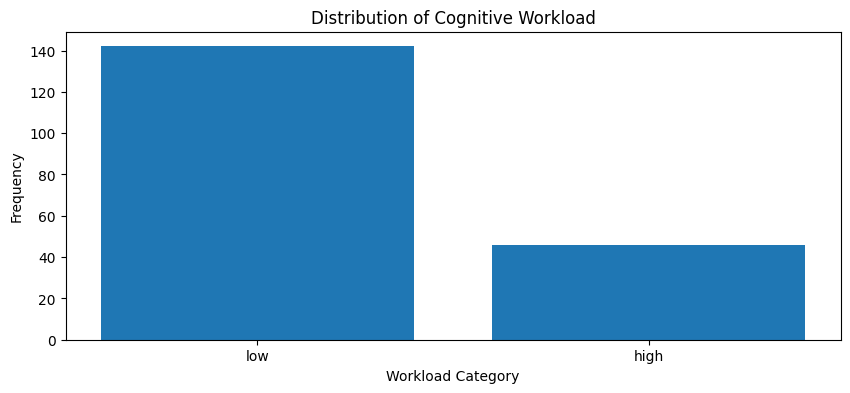

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [13]:
counts = y.value_counts()

plt.figure(figsize=(10, 4))  
plt.bar(counts.index, counts)  

# Adding title and labels
plt.title('Distribution of Cognitive Workload')
plt.xlabel('Workload Category')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Quick check how the labels are distributed
plt.figure(figsize=(10, 4))


In [14]:
# From EDA we know - Given that many of our features do not follow a normal distribution and have varying scales,
# MinMaxScaler will be used, to normalize all features to the same scale. 
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [15]:
# First split: 80% for training and 20% for temp (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Second split: Split the temp into validation and test (50% each of 20% -> 10% each of the original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# We end up with the following split:
# X_train: 80% of the data
# X_val: 10% of the data
# X_test: 10% of the data

In [16]:
# Check splits for label distribution
y_train_decoded = label_encoder.inverse_transform(y_train)
y_val_decoded = label_encoder.inverse_transform(y_val)
y_test_decoded = label_encoder.inverse_transform(y_test)

def print_percentage(decoded_labels, split_name):
    unique, counts = np.unique(decoded_labels, return_counts=True)
    total = counts.sum()
    percentages = 100 * counts / total
    print(f"Percentages for {split_name} ({total} samples):")
    for label, percentage in zip(unique, percentages):
        print(f"{label}: {percentage:.2f}%")

# Apply the function to each set
print_percentage(y_train_decoded, "Training")
print_percentage(y_val_decoded, "Validation")
print_percentage(y_test_decoded, "Testing")

Percentages for Training (150 samples):
high: 22.00%
low: 78.00%
Percentages for Validation (19 samples):
high: 21.05%
low: 78.95%
Percentages for Testing (19 samples):
high: 47.37%
low: 52.63%


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [17]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)


## Implementation

In [18]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(train_features, metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(256, activation='relu',input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

2024-06-27 01:42:11.507909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 01:42:11.508087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 01:42:11.508138: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
EPOCHS = 500
BATCH_SIZE = 32 # Should be higher, but we only have 150 samples in train set

early_stopping = keras.callbacks.EarlyStopping(
    # monitor='val_prc', 
    # monitor='val_accuracy',
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [20]:
# Compile model
model = make_model(X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4608      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 37633 (147.00 KB)
Trainable params: 37633 (147.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Check initial training loss
model.predict(X_train[:10])

results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

1/1 [==============================] - 0s 159ms/step
Loss: 0.5231


In [22]:
# Setting init loss with bias - https://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines
# We want to make sure that the minority class ('high') is accurately classified, thats why we treat it as 'positive' class
# Initial bias can be calculated with np.log(pos/neg)

pos = np.sum(y_train == 0) # 0 is encoded 'high'
neg = np.sum(y_train == 1) # 1 is encoded 'low'
initial_bias =  np.log(pos/neg)
print(f"Initial bias: {initial_bias}")

Initial bias: -1.2656663733312759


The initial bias setting helps because it aligns the initial predictions more closely with the observed distribution of the classes, particularly when there's a significant class imbalance like we have where 'high' is underrepresented. It povides the model with a reasonable starting point. We should hopefully achieve faster convergence as its starting closer to an optimal point and get better initial performance, since the initial predictions aren't so skewed towards the majority ('low') class.

In [23]:
# Check initial loss with bias
model = make_model(X_train, output_bias=initial_bias)
model.predict(X_train[:10])

results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

1/1 [==============================] - 0s 29ms/step
Loss: 1.1647


In [24]:
# Verify that setting initial bias helps
# Without bias
model = make_model(X_train)
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

2024-06-27 01:42:14.816470: I external/local_xla/xla/service/service.cc:168] XLA service 0x7565401a8170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-27 01:42:14.816492: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-27 01:42:14.819810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-27 01:42:14.830056: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1719445334.881665   96557 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [25]:
# With bias
model = make_model(X_train, output_bias=initial_bias)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

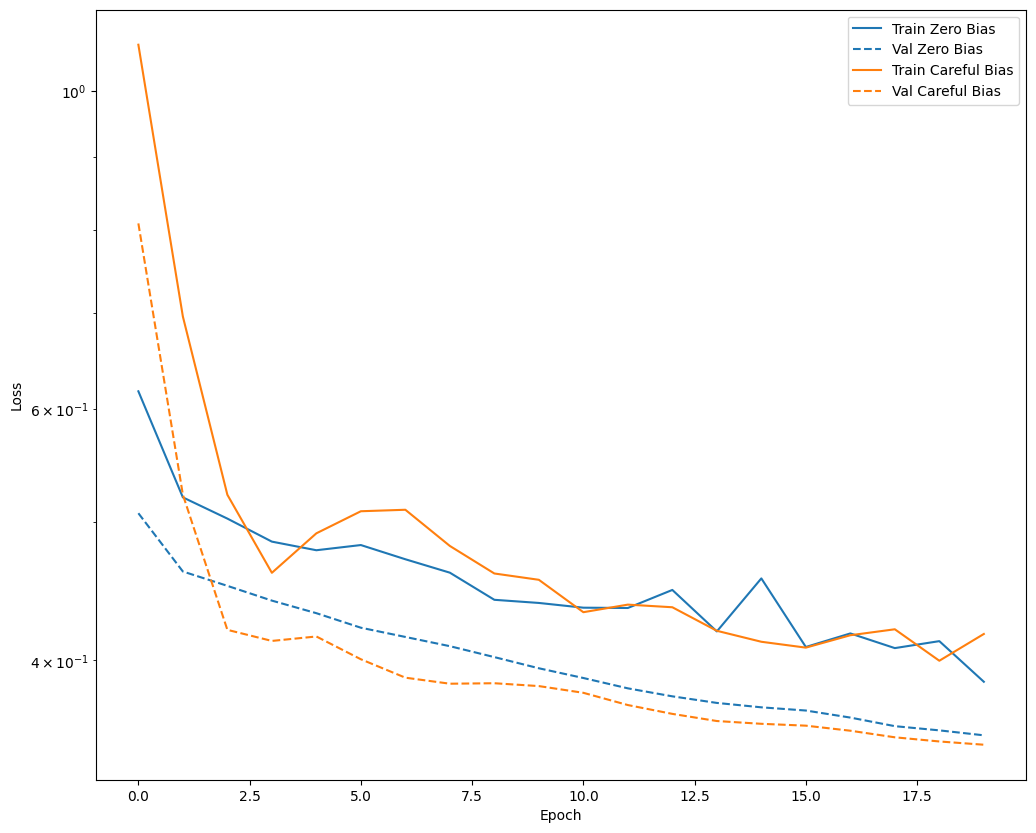

In [26]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

We can see that this didn't really help, the starting loss is actually lower for train and validation without the bias correction. Therefore we will not use it.

In [27]:
# Training the model
model = make_model(X_train)
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
)

Epoch 1/500
5/5 [==============================] - 1s 72ms/step - loss: 0.5151 - cross entropy: 0.4965 - Brier score: 0.1608 - tp: 132.0000 - fp: 35.0000 - tn: 2.0000 - fn: 0.0000e+00 - accuracy: 0.7929 - precision: 0.7904 - recall: 1.0000 - auc: 0.6484 - prc: 0.8668 - val_loss: 0.4919 - val_cross entropy: 0.4919 - val_Brier score: 0.1590 - val_tp: 15.0000 - val_fp: 4.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7895 - val_precision: 0.7895 - val_recall: 1.0000 - val_auc: 0.8333 - val_prc: 0.9540
Epoch 2/500
5/5 [==============================] - 0s 10ms/step - loss: 0.5244 - cross entropy: 0.5244 - Brier score: 0.1703 - tp: 117.0000 - fp: 33.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.7800 - precision: 0.7800 - recall: 1.0000 - auc: 0.5578 - prc: 0.8196 - val_loss: 0.4783 - val_cross entropy: 0.4783 - val_Brier score: 0.1550 - val_tp: 15.0000 - val_fp: 4.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7895 - val_precision: 0.7895 - val_rec

## Evaluation Metrics
- Accuracy
- Precision
- Recall
- F1 Score

In [28]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype('int')  # Convert probabilities to 0 or 1 based on a threshold of 0.5

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

1/1 [==============================] - 0s 28ms/step
Accuracy: 0.5263157894736842
Precision: 0.5263157894736842
Recall: 1.0
F1 Score: 0.6896551724137931


In [29]:
report = classification_report(y_val, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.79      1.00      0.88        15

    accuracy                           0.79        19
   macro avg       0.39      0.50      0.44        19
weighted avg       0.62      0.79      0.70        19



/home/x/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/x/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/x/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


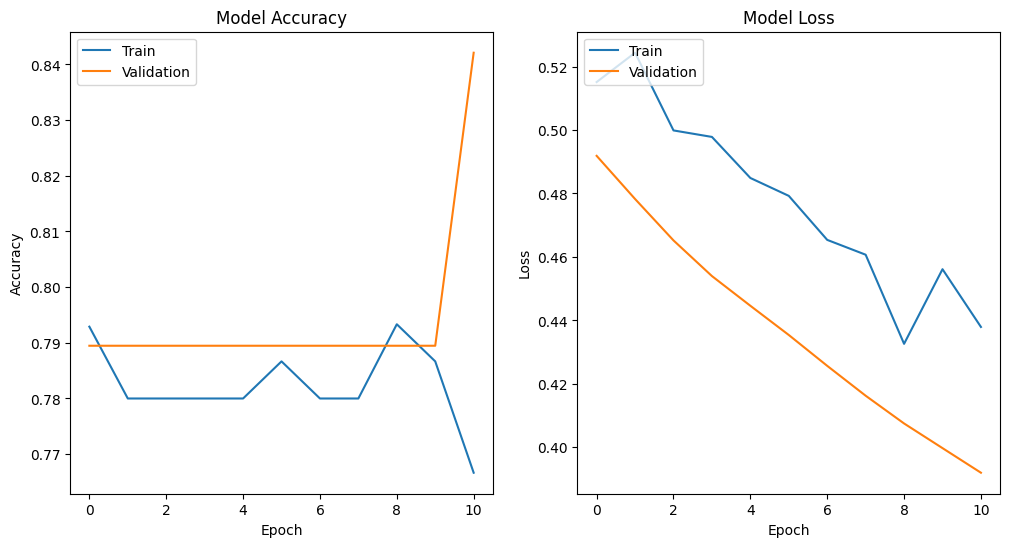

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [31]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


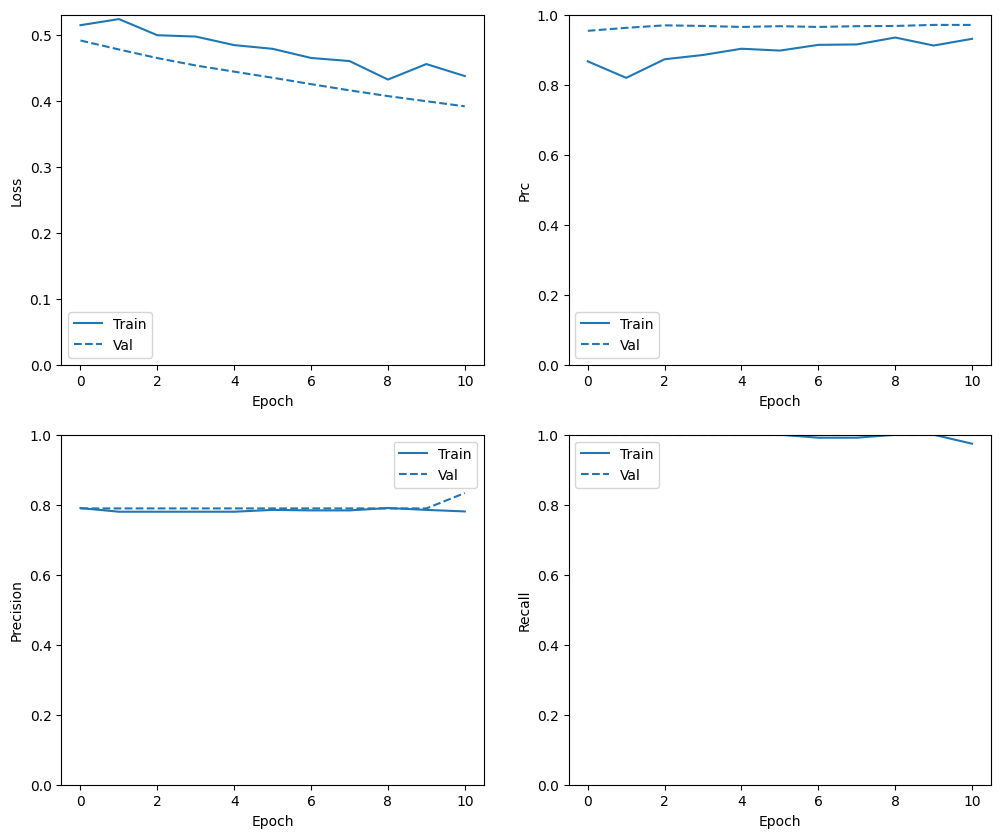

In [32]:
plot_metrics(model_history)

## Comparative Analysis

We'll briefly compare the GNB results with our neural net.

### Results:
GNB Binary:
- Accuracy: 0.6842105263157895
- Precision: 0.6739323055112528
- Recall: 0.6842105263157895
- F1 Score: 0.6771255060728746

GNB Binary with augmented data:
- Accuracy: 0.7255369928400954
- Precision: 0.7298890741720154
- Recall: 0.7255369928400954
- F1 Score: 0.7276105008806703

Neural Network Binary:
- Accuracy: 0.5263157894736842
- Precision: 0.5263157894736842
- Recall: 1.0
- F1 Score: 0.6896551724137931

From the results we can see that the GNB outperforms the NN on this binary classification task.

The GNB is a fairly simple traditional machine learning model, which makes strong (naive) assumptions about the independance of features. The NN on the other hand is more complex and shines through the flexibility and capability to model relationships in large datasets. In our case with only 150 training samples, the neural net is quite prone to overfit and thereform performs worse. This is visible through the high recall and lower precision.

# Solving dataset issues 

As we have seen with the results above, the neural net doesn't perform good at all on this small of a dataset. Furthermore the dataset is seriously unbalanced. We have a lot more data for 'low' cognitive workload than for 'high'. In the several notebooks in this folder we have tried different approaches to solve this problem. Starting with a statistical approach based on means and standard deviations. Followed by attempting to use a generative adversarial network (GAN) to generate the data. Since the features were quite different when comparing the tests, we needed a way to generate features based on a specified test, e.g. Test3  which was the test where the subjects had a time constraint and a secondary task. Thats where a conditional GAN comes in. A conditional GAN allows to input an additional label as input to the generator and will effectively only generate data that looks like the data it has already seen for that label. 

Due to underperforming GAN/cGAN we pivoted from a generative approach using neural networks to generating synthetic data using simple statistical methods. For more details on that approach refer to [Statistical Data Generation Notebook](data_generation_statistic_test.ipynb).

In [33]:
full_path = os.path.join(data_path, 'preprocessed_df_v3.csv')

In [34]:
df = pd.read_csv(full_path)

# Drop not needed features
columns_to_drop = ['mental', 'physical', 'temporal', 'performance', 'effort', 
                   'frustration', 'participant_id', 'test_id']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,test_duration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,gender,age,education,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct
0,33.643950,15.0,43.855534,43.893976,0.059446,0.295946,-0.04,0,28,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,28.484322,32.5,42.935538,43.021599,0.000000,0.175533,-0.04,0,28,18,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465
2,71.423823,62.5,44.704459,44.791630,0.196013,0.196018,-0.04,0,28,18,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050
3,38.163442,35.8,45.762156,45.845470,0.052406,0.288263,-0.04,0,28,18,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927
4,41.748047,15.8,31.492393,31.393101,0.000000,0.143727,-0.10,0,28,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
# Print shape of the dataset
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Number of samples: 4188
Number of features: 18


In [36]:
# Check dataset for NaN values
df.isna().sum()

test_duration                    0
mean                             0
mean_pupil_diameter              0
median_pupil_diameter            0
blinkrate                        0
fixationrate                     0
visual_acuity_logmar             0
gender                           0
age                              0
education                        0
blinkrate_rel                    0
blinkrate_rel_pct                0
fixationrate_rel                 0
fixationrate_rel_pct             0
mean_pupil_diameter_rel          0
mean_pupil_diameter_rel_pct      0
median_pupil_diameter_rel        0
median_pupil_diameter_rel_pct    0
dtype: int64

In [37]:
# Feature and target variable selection
X = df.drop(['mean'], axis=1)
y = df['mean'] # mean is the mean cognitive workload we want to predict
X.head()

,test_duration,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,gender,age,education,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct
0,33.643950,43.855534,43.893976,0.059446,0.295946,-0.04,0,28,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,28.484322,42.935538,43.021599,0.000000,0.175533,-0.04,0,28,18,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465
2,71.423823,44.704459,44.791630,0.196013,0.196018,-0.04,0,28,18,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050
3,38.163442,45.762156,45.845470,0.052406,0.288263,-0.04,0,28,18,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927
4,41.748047,31.492393,31.393101,0.000000,0.143727,-0.10,0,28,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
y.head()

0    15.0
1    32.5
2    62.5
3    35.8
4    15.8
Name: mean, dtype: float64

In [39]:
# Categorize labels to low/high congnitive workload
y = y.map(lambda x: 'low' if x <= 50 else 'high')
y.head(10)

0     low
1     low
2    high
3     low
4     low
5     low
6     low
7    high
8     low
9     low
Name: mean, dtype: object

In [40]:
# Encode labels, sci-kit learn can internally handle strings, but we convert them anyways for good practice
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Labels:")
for original, encoded in zip(y[:10], y_encoded[:10]):
    print(f"Original Label: '{original}', Encoded Label: {encoded}")

Labels:
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1


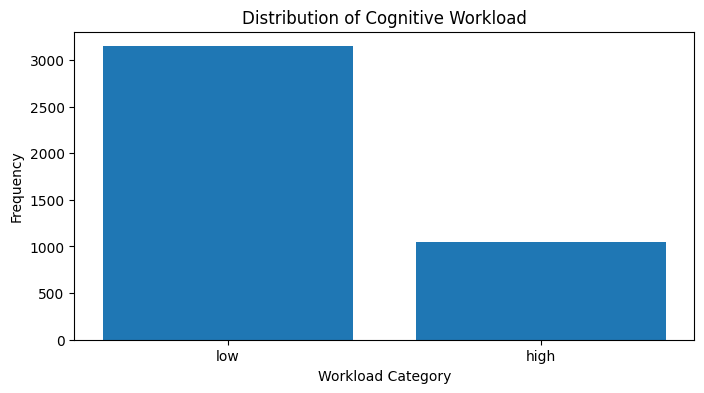

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [41]:
counts = y.value_counts()

plt.figure(figsize=(8, 4))  
plt.bar(counts.index, counts)  

# Adding title and labels
plt.title('Distribution of Cognitive Workload')
plt.xlabel('Workload Category')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Quick check how the labels are distributed
plt.figure(figsize=(10, 4))

In [42]:
# From EDA we know - Given that many of our features do not follow a normal distribution and have varying scales,
# MinMaxScaler will be used, to normalize all features to the same scale. 
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [43]:
# First split: 80% for training and 20% for temp (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Second split: Split the temp into validation and test (50% each of 20% -> 10% each of the original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# We end up with the following split:
# X_train: 80% of the data
# X_val: 10% of the data
# X_test: 10% of the data

In [44]:
# Check splits for label distribution
y_train_decoded = label_encoder.inverse_transform(y_train)
y_val_decoded = label_encoder.inverse_transform(y_val)
y_test_decoded = label_encoder.inverse_transform(y_test)

def print_percentage(decoded_labels, split_name):
    unique, counts = np.unique(decoded_labels, return_counts=True)
    total = counts.sum()
    percentages = 100 * counts / total
    print(f"Percentages for {split_name} ({total} samples):")
    for label, percentage in zip(unique, percentages):
        print(f"{label}: {percentage:.2f}%")

# Apply the function to each set
print_percentage(y_train_decoded, "Training")
print_percentage(y_val_decoded, "Validation")
print_percentage(y_test_decoded, "Testing")

Percentages for Training (3350 samples):
high: 24.84%
low: 75.16%
Percentages for Validation (419 samples):
high: 23.15%
low: 76.85%
Percentages for Testing (419 samples):
high: 27.21%
low: 72.79%


In [45]:
# Compile model
model = make_model(X_train)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               4608      
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 37633 (147.00 KB)
Trainable params: 37633 (147.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Training the model
model = make_model(X_train)
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
)

Epoch 1/500
105/105 [==============================] - 1s 5ms/step - loss: 0.5648 - cross entropy: 0.5638 - Brier score: 0.1895 - tp: 2279.0000 - fp: 717.0000 - tn: 119.0000 - fn: 254.0000 - accuracy: 0.7118 - precision: 0.7607 - recall: 0.8997 - auc: 0.6228 - prc: 0.8247 - val_loss: 0.4811 - val_cross entropy: 0.4811 - val_Brier score: 0.1529 - val_tp: 308.0000 - val_fp: 79.0000 - val_tn: 18.0000 - val_fn: 14.0000 - val_accuracy: 0.7780 - val_precision: 0.7959 - val_recall: 0.9565 - val_auc: 0.7461 - val_prc: 0.8584
Epoch 2/500
105/105 [==============================] - 0s 3ms/step - loss: 0.5104 - cross entropy: 0.5104 - Brier score: 0.1670 - tp: 2345.0000 - fp: 642.0000 - tn: 190.0000 - fn: 173.0000 - accuracy: 0.7567 - precision: 0.7851 - recall: 0.9313 - auc: 0.7125 - prc: 0.8665 - val_loss: 0.4815 - val_cross entropy: 0.4815 - val_Brier score: 0.1535 - val_tp: 295.0000 - val_fp: 68.0000 - val_tn: 29.0000 - val_fn: 27.0000 - val_accuracy: 0.7733 - val_precision: 0.8127 - val_recal

### Evaluation

In [47]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype('int')  # Convert probabilities to 0 or 1 based on a threshold of 0.5

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

14/14 [==============================] - 0s 646us/step
Accuracy: 0.7040572792362768
Precision: 0.8197879858657244
Recall: 0.760655737704918
F1 Score: 0.7891156462585034


## Final Comparative Analysis

We'll briefly compare the GNB results with our neural net.

### Results:
GNB Binary:
- Accuracy: 0.6842105263157895
- Precision: 0.6739323055112528
- Recall: 0.6842105263157895
- F1 Score: 0.6771255060728746

GNB Binary with augmented data:
- Accuracy: 0.7255369928400954
- Precision: 0.7298890741720154
- Recall: 0.7255369928400954
- F1 Score: 0.7276105008806703

Neural Net Binary:
- Accuracy: 0.5789473684210527
- Precision: 0.5555555555555556
- Recall: 1.0
- F1 Score: 0.7142857142857143

Neural Net Binary with augmented data:
- Accuracy: 0.7040572792362768
- Precision: 0.8197879858657244
- Recall: 0.760655737704918
- F1 Score: 0.7891156462585034

|           	| GNB Bin. 	| GNB Bin. Aug. 	| NN Bin. 	| NN Bin. Aug. 	|
|-----------	|----------	|---------------	|---------	|--------------	|
| Accuracy  	| 0.6842   	| 0.7256        	| 0.5789  	| 0.7041       	|
| Precision 	| 0.6739   	| 0.7299        	| 0.5556  	| 0.8198       	|
| Recall    	| 0.6842   	| 0.7255        	| 1       	| 0.7606       	|
| F1        	| 0.6771   	| 0.7276        	| 0.7143  	| 0.7891       	|

The GNB still performs better than the neural net, even on augmented data. 